<a href="https://colab.research.google.com/github/IgorStellet/Casual_Works/blob/main/FP1_2025_2_T5_IgorStellet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Igor Almeida da Silva Gouvêa Stellet

# Tarefa 5

## Parte 1

### Bibliotecas e Funções

In [ ]:
#Libraries that will be used
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
import scipy.stats
import scipy.optimize
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import solve_ivp, odeint
import numpy as np
from IPython.display import HTML
from google.colab import files
from IPython.display import Image
from math import comb
import pandas as pd
from typing import Callable, Tuple
from collections import namedtuple

In [ ]:

# Funções para Parte 1 - EDO + Teoria de Landau


########################### RESOLVEDOR DE EDOS ###########################

#1)-------------- EDO por Scipy (ODEINT) ----------------

def Odeint(dfdt: Callable, f_0: float, t_pts: np.ndarray, args: Tuple=()):
    """
    Integra EDO escalar com scipy.integrate.odeint.

    Parâmetros
    ----------
    dfdt : callable
        RHS com assinatura dfdt(t, y, *args).
    f_0 : float
        Condição inicial y(t_pts[0]) = f_0.
    t_pts : array_like
        Malha temporal (monotônica).
    args : tuple
        Parâmetros extras repassados ao dfdt (ex.: (a, b)).

    Retorna
    -------
    y : ndarray shape (len(t_pts),)
        Solução em cada ponto de t_pts.
    """
    t_pts = np.asarray(t_pts, dtype=float)

    def _for_odeint(y, t, *par):
        # odeint chama como (y, t, *args); reencaminho para (t, y, *args)
        return dfdt(t, y, *par)

    y = odeint(_for_odeint, f_0, t_pts, args=args)
    y = np.asarray(y).ravel()
    return y

#2)-------------- EDO por Scipy (Solve_ivp) ----------------

def Solve_ivp(dfdt: Callable, t_start: float, t_end: float, f_0: float, t_pts: np.ndarray,
              relerr: float = 1e-8, abserr: float = 1e-8, args: Tuple=()):
    """
    Integra EDO escalar com scipy.integrate.solve_ivp (RK45 por padrão).

    Retorna
    -------
    y : ndarray shape (len(t_pts),)
        Solução em cada ponto de t_pts.
    """
    t_pts = np.asarray(t_pts, dtype=float)
    sol = solve_ivp(dfdt, (t_start, t_end), np.atleast_1d(float(f_0)),
                    t_eval=t_pts, rtol=relerr, atol=abserr, args=args)
    # (1 x N) -> (N,)
    return sol.y[0]


#3)-------------- Meu próprio scrpt para EDO ----------------
"""
Em minha pesquisa tenho que resolver uma EDO de modo que uso RungeKutta com passo adapdatitivo que eu mesmo fiz
(baseado em uma referência prévia) aproveito para testá-lo aqui também nessa tarefa e utilizâ-lo como comparativo,
já que a função já estava pronta.
"""


#3.1)-------------- RKCK de quinta ordem ----------------
def _rkck(y: np.ndarray, dydt: np.ndarray, t: float,f: Callable, dt: float, args: tuple = ()) -> Tuple[np.ndarray, np.ndarray]:
    """
    Perform one Cash-Karp 5th-order Runge-Kutta step.

    Parameters
    ----------
    y : array_like
        Current state at time `t`.
    dydt : array_like
        Derivative `dy/dt` at (y, t), usually `f(y, t)`.
    t : float
        Current integration variable.
    f : callable
        Derivative function with signature f(y, t, *args).
    dt : float
        Step size.
    args : tuple, optional
        Extra arguments for f.

    Returns
    -------
    dyout : array_like
        Increment in `y` after one RKCK(5) step.
    yerr : array_like
        Estimated local truncation error (difference between 5th and 4th order).
    """

    # Coefficients (Cash–Karp)
    a2, a3, a4, a5, a6 = 0.2, 0.3, 0.6, 1.0, 0.875
    b21 = 0.2
    b31, b32 = 3/40, 9/40
    b41, b42, b43 = 0.3, -0.9, 1.2
    b51, b52, b53, b54 = -11/54, 2.5, -70/27, 35/27
    b61, b62, b63, b64, b65 = 1631/55296, 175/512, 575/13824, 44275/110592, 253/4096

    c1, c3, c4, c6 = 37/378, 250/621, 125/594, 512/1771

    # Error coefficients (difference between 5th and 4th order)
    dc1 = c1 - 2825/27648
    dc3 = c3 - 18575/48384
    dc4 = c4 - 13525/55296
    dc5 = -277/14336
    dc6 = c6 - 0.25

    # Runge-Kutta stages
    k2 = f(y + dt*b21*dydt, t + a2*dt, *args)
    k3 = f(y + dt*(b31*dydt + b32*k2), t + a3*dt, *args)
    k4 = f(y + dt*(b41*dydt + b42*k2 + b43*k3), t + a4*dt, *args)
    k5 = f(y + dt*(b51*dydt + b52*k2 + b53*k3 + b54*k4), t + a5*dt, *args)
    k6 = f(y + dt*(b61*dydt + b62*k2 + b63*k3 + b64*k4 + b65*k5), t + a6*dt, *args)

    # 5th order solution
    dyout = dt * (c1*dydt + c3*k3 + c4*k4 + c6*k6)

    # Error estimate (difference 5th - 4th order)
    yerr = dt * (dc1*dydt + dc3*k3 + dc4*k4 + dc5*k5 + dc6*k6)

    return dyout, yerr


class IntegrationError(Exception):
    """Custom error for numerical integration failures (used in rkqs)."""
    pass

_rkqs_rval = namedtuple("rkqs_rval", ["Delta_y", "Delta_t", "dtnxt"])

#3.2)-------------- RKCK com passo adapdativo ----------------
def rkqs(y: np.ndarray, dydt: np.ndarray, t: float, f: callable, dt_try: float, epsfrac: float, epsabs: float, args: tuple = ()) -> _rkqs_rval:
    """
    Perform one adaptive 5th-order Runge-Kutta-Cash-Karp step with error control.

    Parameters
    ----------
    y : array_like
        Current state at time `t`.
    dydt : array_like
        Derivative `dy/dt` at (y, t), usually `f(y, t)`.
    t : float
        Current integration variable.
    f : callable
        Derivative function, must have signature f(y, t, *args).
    dt_try : float
        Initial guess for the step size.
    epsfrac : float
        Relative error tolerance.
    epsabs : float
        Absolute error tolerance.
    args : tuple, optional
        Extra arguments to pass to f.

    Returns
    -------
    _rkqs_rval
        Named tuple with:
        - Delta_y : array_like, increment in y
        - Delta_t : float, actual step size taken
        - dtnxt   : float, suggested next step size

    Raises
    ------
    IntegrationError
        If step size underflows (too small to represent).
    """
    dt = dt_try
    eps = np.finfo(float).eps  # machine epsilon

    while True:
        # Single RKCK step
        dy, yerr = _rkck(y, dydt, t, f, dt, args)

        # Compute normalized error (max over components)
        denom = np.maximum(np.abs(y), eps) * epsfrac
        err_ratio = np.abs(yerr) / np.maximum(epsabs, denom)
        errmax = np.max(err_ratio)

        if errmax < 1.0:
            # Step succeeded
            break

        # Reduce step size and retry
        dttemp = 0.9 * dt * errmax**-0.25
        dt = max(dttemp, 0.1 * dt) if dt > 0 else min(dttemp, 0.1 * dt)

        if t + dt == t:
            raise IntegrationError(
                f"Step size underflow at t={t:.6e}, dt={dt:.6e}"
            )

    # Estimate next step
    if errmax > 1.89e-4:
        dtnext = 0.9 * dt * errmax**-0.2
    else:
        dtnext = 5.0 * dt

    return _rkqs_rval(dy, dt, dtnext)


########################### Solução Exata ###########################
#1)-------------- Solução exata de m para todo t ----------------

def exact_m(t, m0, a, b):
    """
    Solução exata para dm/dt = -a m - b m^3, devolvendo o ramo com o sinal de m0.

    Parâmetros
    ----------
    t : array_like
        Tempos.
    m0 : float
        Condição inicial m(0).
    a, b : float
        Parâmetros (com b>0 para estabilidade Landau padrão).

    Retorna
    -------
    m(t) : ndarray
        Solução analítica no(s) tempo(s) t.
    """
    t = np.asarray(t, dtype=float)
    m0 = float(m0)
    sgn = np.sign(m0) if m0 != 0.0 else 1.0  # define ramo; se m0==0, escolhe + por convenção

    if np.isclose(a, 0.0):
        u = (m0*m0) / (1.0 + 2.0*b*m0*m0*t)
    else:
        e2at = np.exp(2.0*a*t)
        e2atm1 = np.expm1(2.0*a*t)
        denom = a*e2at + b*(m0*m0)*e2atm1
        u = (a*(m0*m0)) / denom

    # Evita ruído numérico negativo de ordem ~1e-16
    u = np.maximum(u, 0.0)
    return sgn * np.sqrt(u)


#2)-------------- Solução no limite assintótico ----------------

def asymptotic_m(t, m0, a, b):
    """
    Aproximações assintóticas para dm/dt = -a m - b m^3.
    Retorna o ramo compatível com o sinal de m0.
    """
    t = np.asarray(t, dtype=float)
    sgn = np.sign(m0) if m0 != 0.0 else 1.0
    m0 = float(m0)

    if a > 0:
        # Amplitude correta derivada da solução exata
        C = sgn * abs(m0) * np.sqrt(a / (a + b * m0 * m0))
        return C * np.exp(-a * t)

    elif np.isclose(a, 0.0):
        # Assintótico puro: sgn / sqrt(2 b t)
        # (evita divisão por zero no t=0)
        t_safe = np.maximum(t, 1e-30)
        return m0 / np.sqrt(1.0 + 2.0 * b * m0 * m0 * t) # or t_safe
        # Se preferir forma "exata" para a=0:
        # return m0 / np.sqrt(1.0 + 2.0 * b * m0 * m0 * t)

    else:  # a < 0
        m_star = sgn * np.sqrt(-a / b)
        return m_star + (m0 - m_star) * np.exp(2.0 * a * t)



### 1. Resolvendo numericamente EDO e comparando com a solução (Considerando toda evolução temporal)

In [ ]:
################################################################################
#Definindo EDO e parâmetros iniciais.
def f_rhs(t, m, a, b):
  """
  \dot m = -am -bm^3 (equação diferencial para resolver)
  """
  return -a*m - b*m**3

def integrate_rkck_adaptive(df: Callable, t0: float, t_end: float, y0: float, dt_try: float,
                             epsfrac: float=1e-8, epsabs: float=1e-8, args: Tuple=()):
    """
    Integra y' = df(y, t, *args) de t0 a t_end com passo adaptativo (RKCK).
    Retorna (ts, ys, dts).
    """
    y = float(y0)
    t = float(t0)
    dt = float(dt_try)
    ts = [t]
    ys = [y]
    dts = []

    while t < t_end:
        if t + dt > t_end:
            dt = t_end - t

        dydt = df(y, t, *args)  # atenção: df(y, t, *args) (assinatura para RKCK)
        dy, dt_used, dt_next = rkqs(y, dydt, t, df, dt, epsfrac, epsabs, args=args)
        y = y + float(dy)
        t = t + float(dt_used)
        ts.append(t)
        ys.append(y)
        dts.append(float(dt_used))
        dt = float(dt_next)

    return np.array(ts), np.array(ys), np.array(dts)

# -----------------------------
# 1) Função principal para gerar gráficos e prints
# -----------------------------
def landau_edo_compare_and_plot(
    t_start: float = 0.0,
    t_end: float   = 40,
    n_pts: int     = 10000,
    a: float       = 0.5,
    b: float       = 1.0,
    m0: float      = 1.0,
    dt_try: float  = None,
    relerr: float  = 1e-8,
    abserr: float  = 1e-8
):
    """
    Gera três gráficos (um por método numérico sobreposto com a solução exata)
    e imprime erros absoluto/relativo resumidos.
    """
    # malha temporal comum para odeint/solve_ivp/exato
    t_pts = np.linspace(t_start, t_end, int(n_pts))

    # Interpretação física pedida
    fase = "desordenada (m→0)" if a > 0 else (f"ordenada (|m|→sqrt(-a/b)={np.sqrt(abs(a/b)):.2f})" if a < 0 else "marginal (a=0)")
    estado_ini = "ordenado" if abs(m0) > 0 else "desordenado"

    print(f"a = {a:.6g}  → fase {fase}")
    print(f"b = {b:.6g}  (espera-se b>0 para estabilidade de Landau)")
    print(f"m0 = {m0:.6g}  → estado inicial {estado_ini}")
    print(f"Janela temporal: [{t_start:.3g}, {t_end:.3g}] com {int(n_pts)} pontos\n")

    # Solução exata
    m_exact_tpts = exact_m(t_pts, m0, a, b)

    # Odeint / Solve_ivp (ambas usam dfdt(t, y, *args))
    dfdt = lambda t, y, *par: f_rhs(t, y, *par)
    m_odeint = Odeint(dfdt, m0, t_pts, args=(a, b))
    m_ivp    = Solve_ivp(dfdt, t_start, t_end, m0, t_pts, relerr=relerr, abserr=abserr, args=(a, b))

    # RKCK adaptativo: precisa de df(y, t, *args)
    df_rk = lambda y, t, *par: f_rhs(t, y, *par)
    if dt_try is None:
        dt_try = (t_end - t_start) / 1000.0  # palpite inicial
    ts_rk, m_rk, dts_rk = integrate_rkck_adaptive(df_rk, t_start, t_end, m0, dt_try, epsfrac=relerr, epsabs=abserr, args=(a, b))
    m_exact_ts_rk = exact_m(ts_rk, m0, a, b)

    # Erros (resumos): max abs, RMS rel
    def summarize_errors(num, ref):
        abs_err = np.abs(num - ref)
        with np.errstate(divide='ignore', invalid='ignore'):
            rel_err = abs_err / np.maximum(np.abs(ref), 1e-14)
        max_abs = float(np.max(abs_err))
        rms_rel = float(np.sqrt(np.mean(np.square(rel_err))))
        return max_abs, rms_rel

    max_abs_oi, rms_rel_oi = summarize_errors(m_odeint, m_exact_tpts)
    max_abs_ivp, rms_rel_ivp = summarize_errors(m_ivp, m_exact_tpts)
    max_abs_rk, rms_rel_rk   = summarize_errors(m_rk, m_exact_ts_rk)

    print(f"Últimos m's medidos: [m_exct = {m_exact_tpts[-1]:.2f}, m_ODE = {m_odeint[-1]:.2f}, m_ivp = {m_ivp[-1]:.2f}, m_rkck = {m_rk[-1]:.2f}]")

    print("Erros vs. solução exata (resumos):")
    print(f"  ODEINT  → max |Δm| = {max_abs_oi:.3e} ;  RMS rel = {rms_rel_oi:.3e}")
    print(f"  SOLVE_IVP → max |Δm| = {max_abs_ivp:.3e} ;  RMS rel = {rms_rel_ivp:.3e}")
    print(f"  RKCK(adapt.) → max |Δm| = {max_abs_rk:.3e} ;  RMS rel = {rms_rel_rk:.3e}")

    # --- Subplots: 1 linha, 3 colunas, tudo numa única figura ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    ax0, ax1, ax2 = axes

    # (1) ODEINT vs Exata
    ax0.plot(t_pts, m_exact_tpts, label="Exact")
    ax0.plot(t_pts, m_odeint, linestyle="--", label="ODEINT")
    ax0.set_title(f"ODEINT vs Exact (a={a}, b={b}, m0={m0})")
    ax0.set_xlabel("t")
    ax0.set_ylabel("m(t)")
    ax0.legend()
    ax0.grid(True, linestyle=":", alpha=0.5)

    # (2) solve_ivp vs Exata
    ax1.plot(t_pts, m_exact_tpts, label="Exact")
    ax1.plot(t_pts, m_ivp, linestyle="--", label="solve_ivp (RK45)")
    ax1.set_title(f"solve_ivp vs Exact (a={a}, b={b}, m0={m0})")
    ax1.set_xlabel("t")
    ax1.legend()
    ax1.grid(True, linestyle=":", alpha=0.5)

    # (3) RKCK adaptativo vs Exata
    ax2.plot(ts_rk, m_exact_ts_rk, label="Exact")
    ax2.plot(ts_rk, m_rk, linestyle="--", label="RKCK adaptive")
    ax2.set_title(f"RKCK(adapt.) vs Exact (a={a}, b={b}, m0={m0})")
    ax2.set_xlabel("t")
    ax2.legend()
    ax2.grid(True, linestyle=":", alpha=0.5)

    fig.suptitle("Landau ODE — Comparisons", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()


<>:5: SyntaxWarning: invalid escape sequence '\d'
<>:5: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3819458507.py:5: SyntaxWarning: invalid escape sequence '\d'
  \dot m = -am -bm^3 (equação diferencial para resolver)


a = 0.5  → fase desordenada (m→0)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.00, m_ODE = 0.00, m_ivp = 0.00, m_rkck = 0.00]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 3.558e-08 ;  RMS rel = 1.552e-02
  SOLVE_IVP → max |Δm| = 2.391e-08 ;  RMS rel = 6.146e-02
  RKCK(adapt.) → max |Δm| = 5.048e-09 ;  RMS rel = 3.285e-02


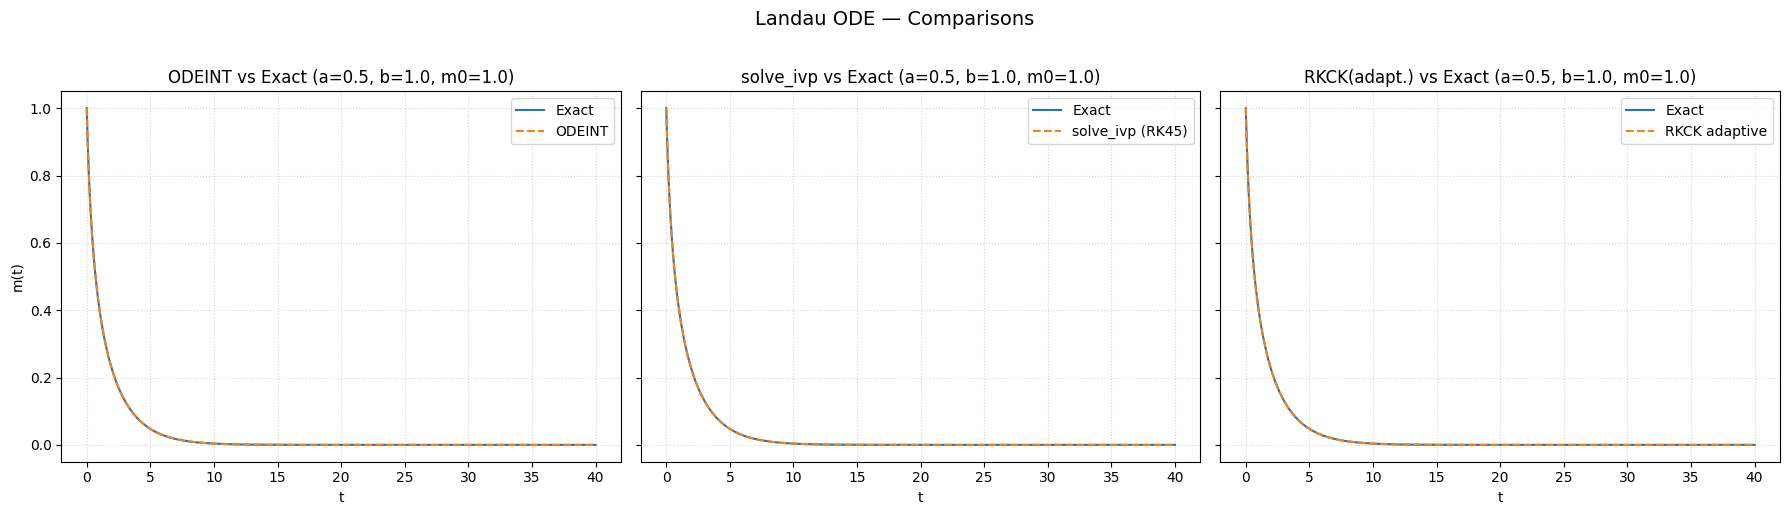

In [ ]:
landau_edo_compare_and_plot(a= 0.5, b = 1.0, m0 = 1.0 ) # Vai para fase desorneda (estado começa ordenado)

a = -0.5  → fase ordenada (|m|→sqrt(-a/b)=0.71)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.71, m_ODE = 0.71, m_ivp = 0.71, m_rkck = 0.71]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 3.303e-08 ;  RMS rel = 6.391e-09
  SOLVE_IVP → max |Δm| = 1.332e-08 ;  RMS rel = 5.815e-09
  RKCK(adapt.) → max |Δm| = 1.151e-08 ;  RMS rel = 4.345e-09


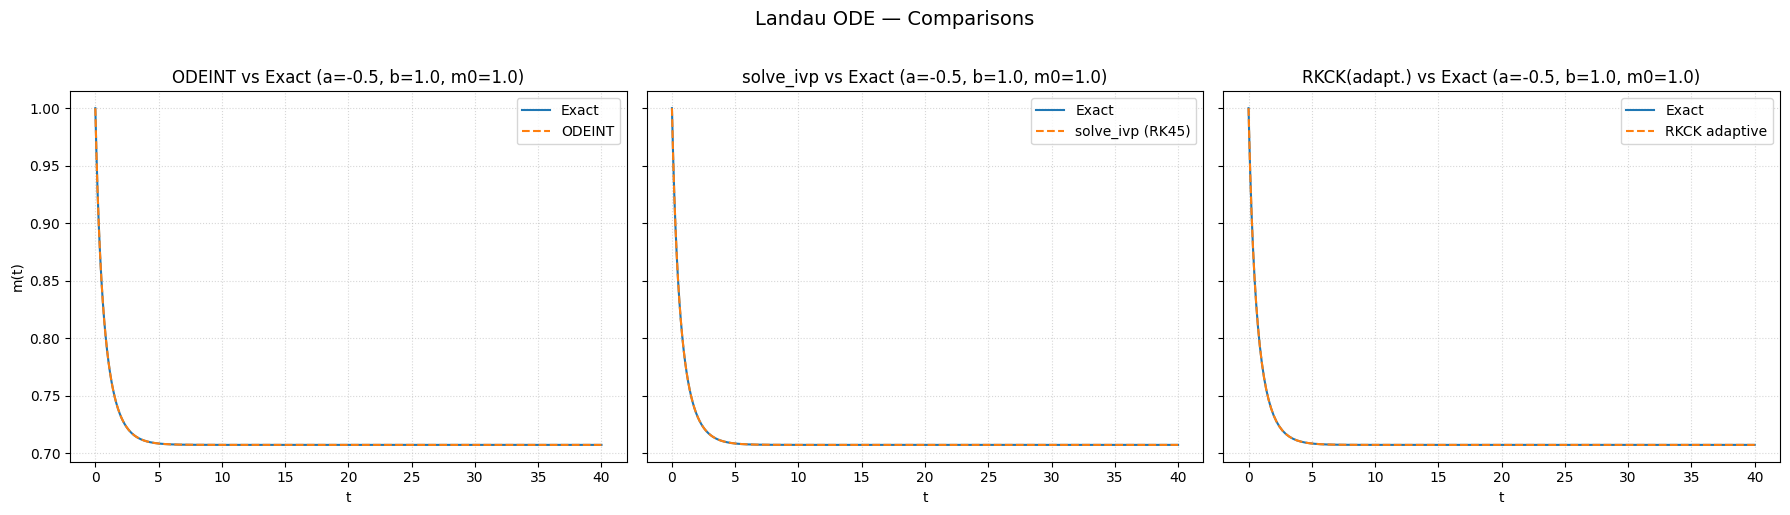

In [ ]:
landau_edo_compare_and_plot(a=-0.5, b=1.0, m0=1.0)  # Estado continua ordenado em outro valor (duplo-poço) - Começa ordenado e vai para sqrt(-a/b) mantendo a quebra de simetria

a = -0.5  → fase ordenada (|m|→sqrt(-a/b)=0.71)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1e-06  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.71, m_ODE = 0.71, m_ivp = 0.71, m_rkck = 0.71]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 1.703e-03 ;  RMS rel = 4.481e-03
  SOLVE_IVP → max |Δm| = 1.224e-05 ;  RMS rel = 1.126e-04
  RKCK(adapt.) → max |Δm| = 2.039e-03 ;  RMS rel = 4.716e-03


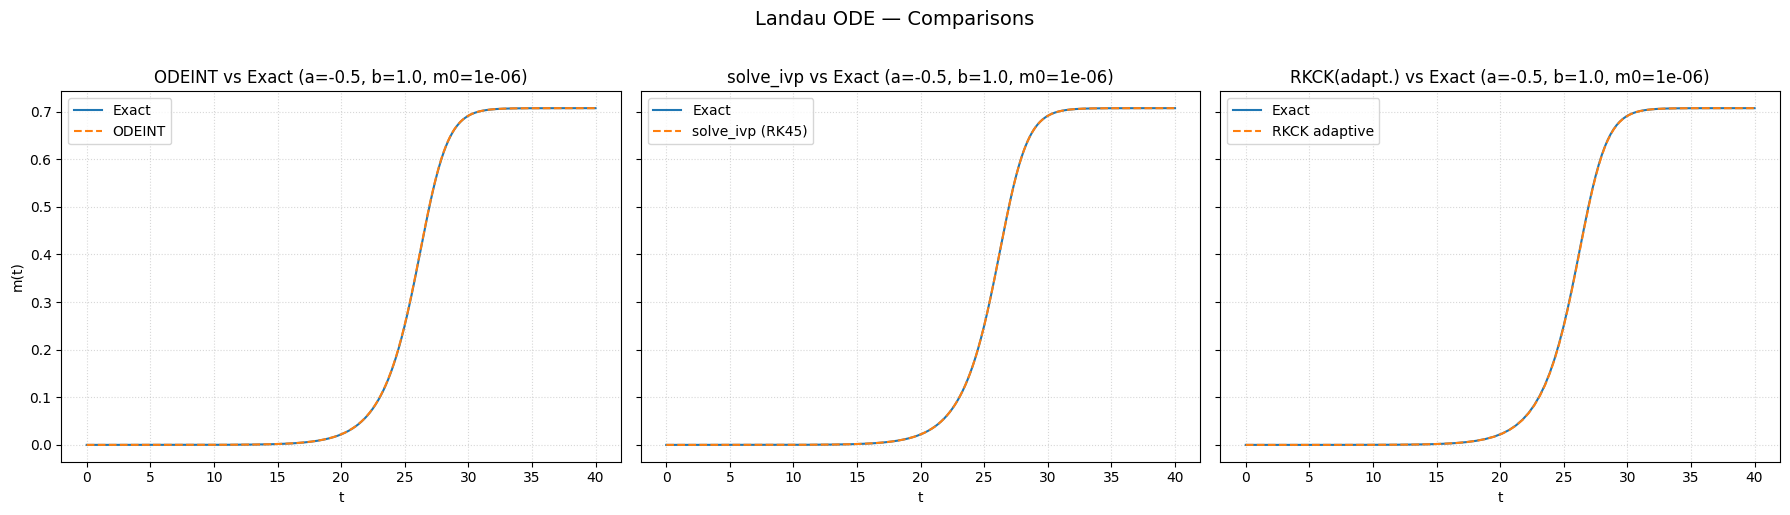

In [ ]:
landau_edo_compare_and_plot(a=-0.5, b=1.0, m0=1e-6) # Começa bem desordenado e vai para fase ordenada  sqrt(-a/b) realizando a quebra de simetria expontânea

**Discussão dos resultados**

Observando o gráfico, notamos que o parâmetro de ordem (m) indica o grau de ordenamento do sistema ao longo do tempo. Para (m) próximo de 0 o sistema está **desordenado**; para (|m|) grande o sistema está **ordenado**. Se normalizarmos esse parâmetro, podemos interpretar (m=1) como o estado de maior ordenamento. Além de (m), entra o parâmetro crítico $(p_c)$, refletido no código pelo coeficiente (a), com $(a \propto (p-p_c))$. Assim, para $(a< 0)$ (ou (p< p_c)) o sistema tende a se **ordenar** ao longo do tempo, escolhendo um estado mais favorável; já para $(a>0)$ (ou $(p>p_c)$) ocorre o oposto: o sistema tende a se **desordenar** com o passar do tempo. Isso aparece nitidamente nos gráficos: para (a>0) vemos o **desordenamento** $(m\to 0)$; para (a< 0) vemos o **ordenamento** em alguma fase estável ($(m\to \pm\sqrt{-a/b})$, e se (m) estiver normalizado isso corresponde a tender a $(\pm 1)$).

Isso fica claro ao lembrarmos da tarefa 3, onde tratamos de ferromagnetos/paramagnetos. Lá, o parâmetro (m) que media ordem/desordem era a magnetização média dos spins, com módulo entre 0 e 1; e o coeficiente (a) era controlado pela **temperatura**. Acima da temperatura crítica $(T_c)$ ((a>0)), o sistema recupera a simetria e cai para a **desordem** (spins desalinhados, $(m\to 0)$). Abaixo de $(T_c)$ $(a < 0)$, ocorre **quebra espontânea de simetria** e o sistema escolhe um dos dois estados ordenados, $(m=\pm 1)$ (no caso normalizado). É exatamente o que vemos aqui. Reforço que, nesses gráficos, assumimos simetria $(m\to -m)$ (o potencial é invariante sob troca de sinal) e a transição é **suave/contínua** (de segunda ordem na linguagem de Landau para (b>0)).

Na minha pesquisa, estudo também a transição de fase do **campo de Higgs**. A escala crítica está no regime eletrofraco, então o parâmetro de controle (p) também é a **temperatura**, enquanto o parâmetro de ordem é $(\phi)$, o valor de vácuo do campo de Higgs acoplado à matéria. No Modelo Padrão, com a massa do Higgs medida, a transição eletrofraca é **suave (cross-over)** [não estritamente de 2ª ordem ], mas sem descontinuidade de (m). Já em extensões do Modelo Padrão, pode surgir uma **transição de 1ª ordem**, típica quando o potencial ganha **termos ímpares** (por exemplo, cúbico em $(\phi)$) que quebram a simetria $(\phi\to -\phi)$ e geram barreira entre mínimos. Isso é particularmente interessante porque uma transição de 1ª ordem forte pode produzir **ondas gravitacionais** observáveis no futuro, permitindo **testar e possivelmente refutar** cenários dessa nova física no setor escalar.

### 2. Resolvendo a EDO descrita no regime assintótico (tempos longos)

In [ ]:
# -----------------------------
# 1) Função principal para gerar gráficos e prints
# -----------------------------
def landau_edo_compare_and_plot_asymptotic(
    t_start: float = 0,
    t_end: float   = 40,
    n_pts: int     = 10000,
    a: float       = 0.5,
    b: float       = 1.0,
    m0: float      = 1.0,
    dt_try: float  = None,
    relerr: float  = 1e-8,
    abserr: float  = 1e-8,
    mask: float = 10
):
    """
    Gera três gráficos (um por método numérico sobreposto com a solução exata)
    e imprime erros absoluto/relativo resumidos.
    """
    # malha temporal comum para odeint/solve_ivp/exato
    t_pts = np.linspace(t_start, t_end, int(n_pts))

    # Interpretação física pedida
    fase = "desordenada (m→0)" if a > 0 else (f"ordenada (|m|→sqrt(-a/b)={np.sqrt(abs(a/b)):.2f})" if a < 0 else "marginal (a=0)")
    estado_ini = "ordenado" if abs(m0) > 0 else "desordenado"

    print(f"a = {a:.6g}  → fase {fase}")
    print(f"b = {b:.6g}  (espera-se b>0 para estabilidade de Landau)")
    print(f"m0 = {m0:.6g}  → estado inicial {estado_ini}")
    print(f"Janela temporal: [{t_start:.3g}, {t_end:.3g}] com {int(n_pts)} pontos\n")

    # Solução exata assintótica
    m_exact_tpts = asymptotic_m(t_pts, m0, a, b )

    # Odeint / Solve_ivp (ambas usam dfdt(t, y, *args))
    dfdt = lambda t, y, *par: f_rhs(t, y, *par)
    m_odeint = Odeint(dfdt, m0, t_pts, args=(a, b))
    m_ivp    = Solve_ivp(dfdt, t_start, t_end, m0, t_pts, relerr=relerr, abserr=abserr, args=(a, b))

    # RKCK adaptativo: precisa de df(y, t, *args)
    df_rk = lambda y, t, *par: f_rhs(t, y, *par)
    if dt_try is None:
        dt_try = (t_end - t_start) / 1000.0  # palpite inicial
    ts_rk, m_rk, dts_rk = integrate_rkck_adaptive(df_rk, t_start, t_end, m0, dt_try, epsfrac=relerr, epsabs=abserr, args=(a, b))
    m_exact_ts_rk = asymptotic_m(ts_rk, m0, a, b)

    # Erros (resumos): max abs, RMS rel
    def summarize_errors(num, ref):
        abs_err = np.abs(num - ref)
        with np.errstate(divide='ignore', invalid='ignore'):
            rel_err = abs_err / np.maximum(np.abs(ref), 1e-14)
        max_abs = float(np.max(abs_err))
        rms_rel = float(np.sqrt(np.mean(np.square(rel_err))))
        return max_abs, rms_rel

    max_abs_oi, rms_rel_oi = summarize_errors(m_odeint, m_exact_tpts)
    max_abs_ivp, rms_rel_ivp = summarize_errors(m_ivp, m_exact_tpts)
    max_abs_rk, rms_rel_rk   = summarize_errors(m_rk, m_exact_ts_rk)

    print(f"Últimos m's medidos: [m_exct = {m_exact_tpts[-1]:.2f}, m_ODE = {m_odeint[-1]:.2f}, m_ivp = {m_ivp[-1]:.2f}, m_rkck = {m_rk[-1]:.2f}]")

    print("Erros vs. solução exata (resumos):")
    print(f"  ODEINT  → max |Δm| = {max_abs_oi:.3e} ;  RMS rel = {rms_rel_oi:.3e}")
    print(f"  SOLVE_IVP → max |Δm| = {max_abs_ivp:.3e} ;  RMS rel = {rms_rel_ivp:.3e}")
    print(f"  RKCK(adapt.) → max |Δm| = {max_abs_rk:.3e} ;  RMS rel = {rms_rel_rk:.3e}")

    # --- Subplots: 1 linha, 3 colunas, tudo numa única figura ---
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    ax0, ax1, ax2 = axes
    corte = t_pts > mask

    # (1) ODEINT vs Exata
    ax0.plot(t_pts[corte], m_exact_tpts[corte], label="Exact")
    ax0.plot(t_pts[corte], m_odeint[corte], linestyle="--", label="ODEINT")
    ax0.set_title(f"ODEINT vs Exact (a={a}, b={b}, m0={m0})")
    ax0.set_xlabel("t")
    ax0.set_ylabel("m(t)")
    ax0.legend()
    ax0.grid(True, linestyle=":", alpha=0.5)

    # (2) solve_ivp vs Exata
    ax1.plot(t_pts[corte], m_exact_tpts[corte], label="Exact")
    ax1.plot(t_pts[corte], m_ivp[corte], linestyle="--", label="solve_ivp (RK45)")
    ax1.set_title(f"solve_ivp vs Exact (a={a}, b={b}, m0={m0})")
    ax1.set_xlabel("t")
    ax1.legend()
    ax1.grid(True, linestyle=":", alpha=0.5)

    # (3) RKCK adaptativo vs Exata
    corte = ts_rk > mask
    ax2.plot(ts_rk[corte], m_exact_ts_rk[corte], label="Exact")
    ax2.plot(ts_rk[corte], m_rk[corte], linestyle="--", label="RKCK adaptive")
    ax2.set_title(f"RKCK(adapt.) vs Exact (a={a}, b={b}, m0={m0})")
    ax2.set_xlabel("t")
    ax2.legend()
    ax2.grid(True, linestyle=":", alpha=0.5)

    fig.suptitle("Landau ODE — Comparisons", y=1.02, fontsize=14)
    fig.tight_layout()
    plt.show()


a = 0.5  → fase desordenada (m→0)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.00, m_ODE = 0.00, m_ivp = 0.00, m_rkck = 0.00]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 4.226e-01 ;  RMS rel = 6.319e-02
  SOLVE_IVP → max |Δm| = 4.226e-01 ;  RMS rel = 8.677e-02
  RKCK(adapt.) → max |Δm| = 4.226e-01 ;  RMS rel = 2.214e-01


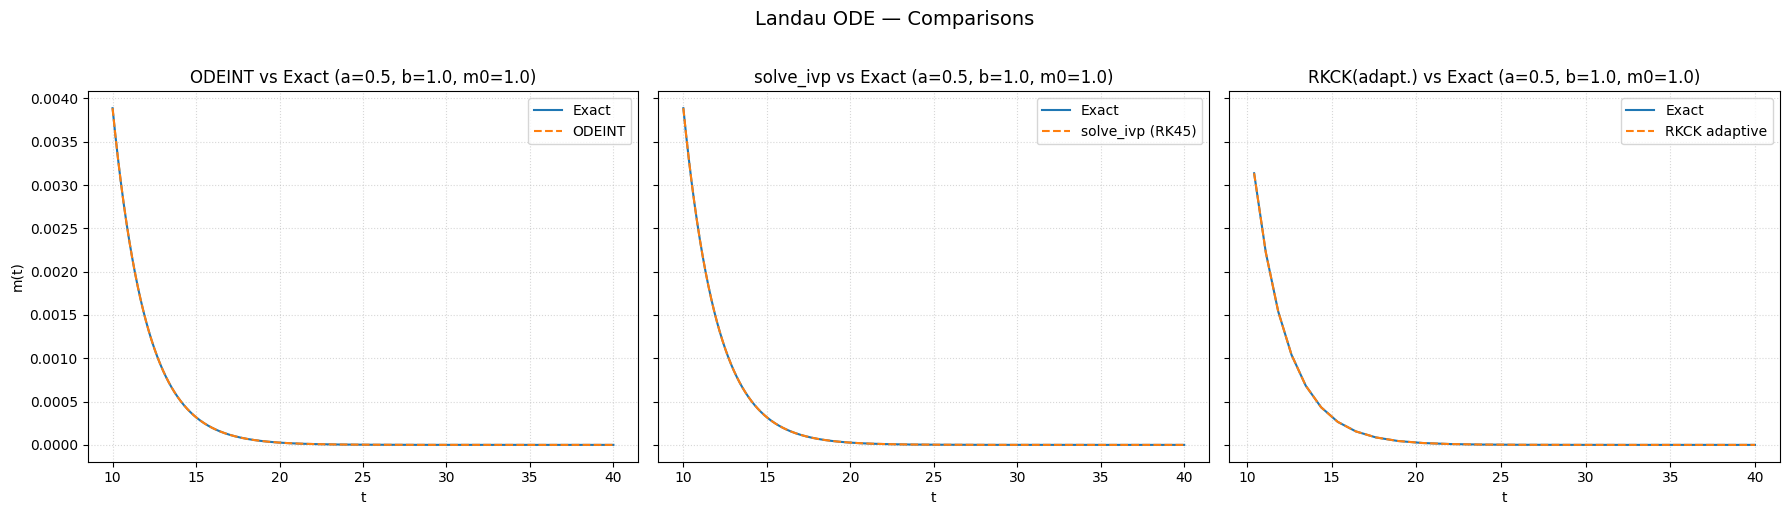

In [ ]:
landau_edo_compare_and_plot_asymptotic(a= 0.5, b = 1.0, m0 = 1.0, mask=10 ) # Vai para fase desorneda (estado começa ordenado)

a = -0.5  → fase ordenada (|m|→sqrt(-a/b)=0.71)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.71, m_ODE = 0.71, m_ivp = 0.71, m_rkck = 0.71]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 3.781e-02 ;  RMS rel = 7.855e-03
  SOLVE_IVP → max |Δm| = 3.781e-02 ;  RMS rel = 7.855e-03
  RKCK(adapt.) → max |Δm| = 3.772e-02 ;  RMS rel = 1.899e-02


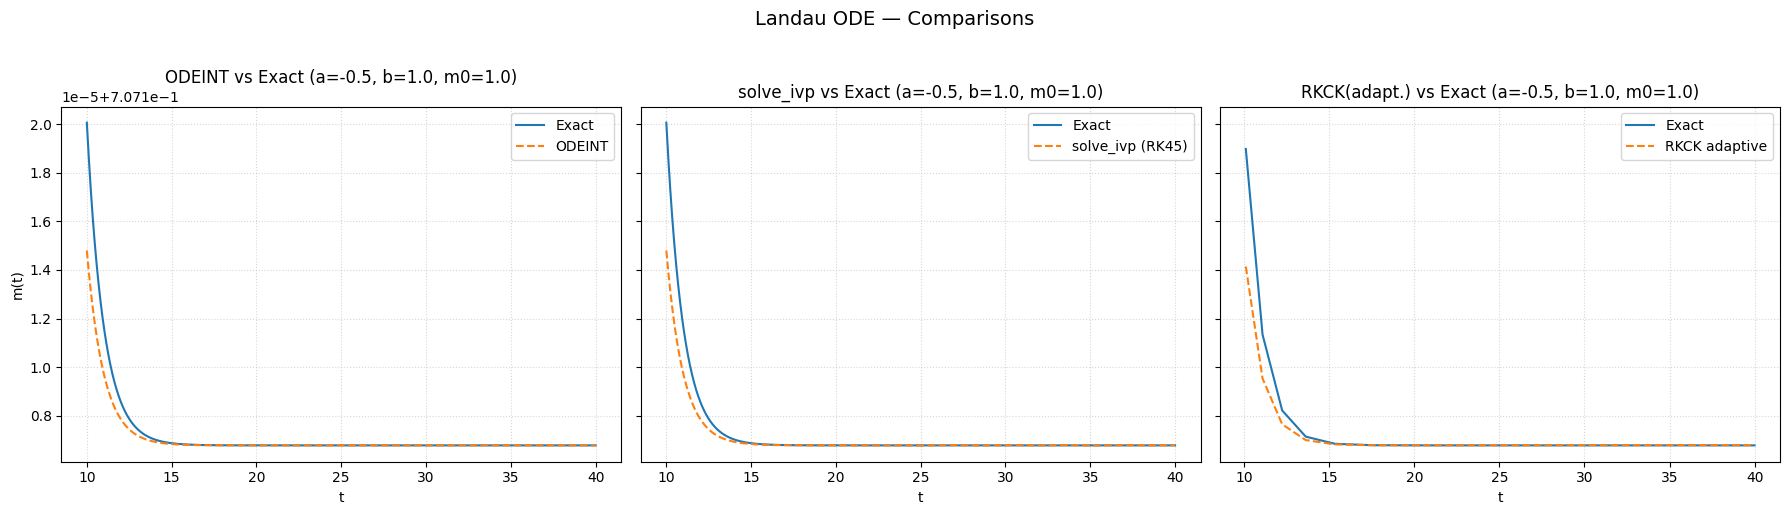

In [ ]:
landau_edo_compare_and_plot_asymptotic(a=-0.5, b=1.0, m0=1.0, mask=10)  # Estado continua ordenado em outro valor (duplo-poço) - Começa ordenado e vai para sqrt(-a/b) mantendo a quebra de simetria

a = -0.5  → fase ordenada (|m|→sqrt(-a/b)=0.71)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1e-06  → estado inicial ordenado
Janela temporal: [0, 70] com 10000 pontos

Últimos m's medidos: [m_exct = 0.71, m_ODE = 0.71, m_ivp = 0.71, m_rkck = 0.71]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 7.069e-01 ;  RMS rel = 5.873e-01
  SOLVE_IVP → max |Δm| = 7.069e-01 ;  RMS rel = 5.875e-01
  RKCK(adapt.) → max |Δm| = 7.069e-01 ;  RMS rel = 5.751e-01


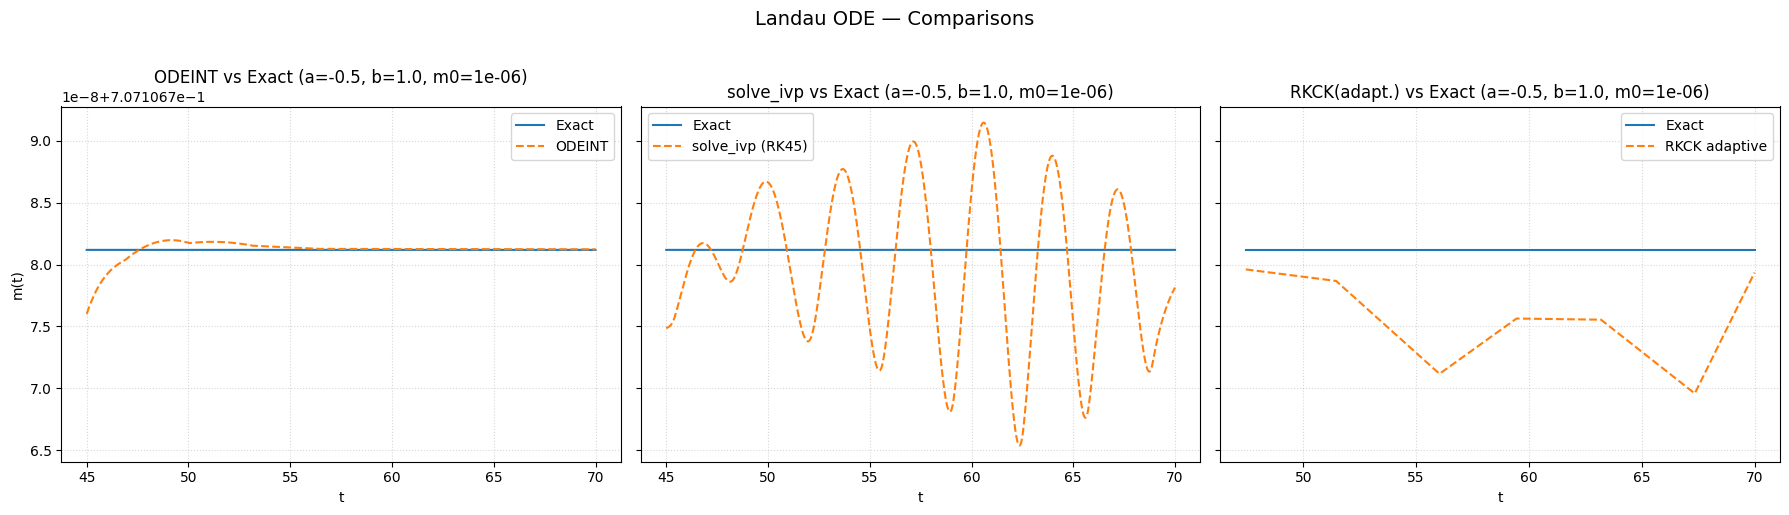

In [ ]:
landau_edo_compare_and_plot_asymptotic(a=-0.5, b=1.0, m0=1e-6,t_end=70, mask=45) # Começa bem desordenado e vai para fase ordenada  sqrt(-a/b) realizando a quebra de simetria expontânea

**Discussão dos resultados**

Observamos que para tempos longos a reta assintótica já passa a ter boas correspondência a partir de t>10. Entretanto, para o caso de m muito próximo de 0 (desordem) e com $a< 0$ (seguindo para o ordenamento) observamos que a aproximação só passa a valer para t muito grande e ainda possui uma oscilação em torno da solução exata para solve_ivp. Isso ocorre pois demoramos mais (menos) tempo para ordenar (desordenadar) o estado do que para levá-lo a desordem (ordem) partindo de m próximo de 0 (próximo de 1)

### 3. Resolver numericamente a EDO no regime assintótico em cima do ponto crítico (a=0)

a = 0  → fase marginal (a=0)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.11, m_ODE = 0.11, m_ivp = 0.11, m_rkck = 0.11]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 3.461e-08 ;  RMS rel = 1.439e-07
  SOLVE_IVP → max |Δm| = 2.032e-08 ;  RMS rel = 3.615e-08
  RKCK(adapt.) → max |Δm| = 7.582e-10 ;  RMS rel = 2.906e-09


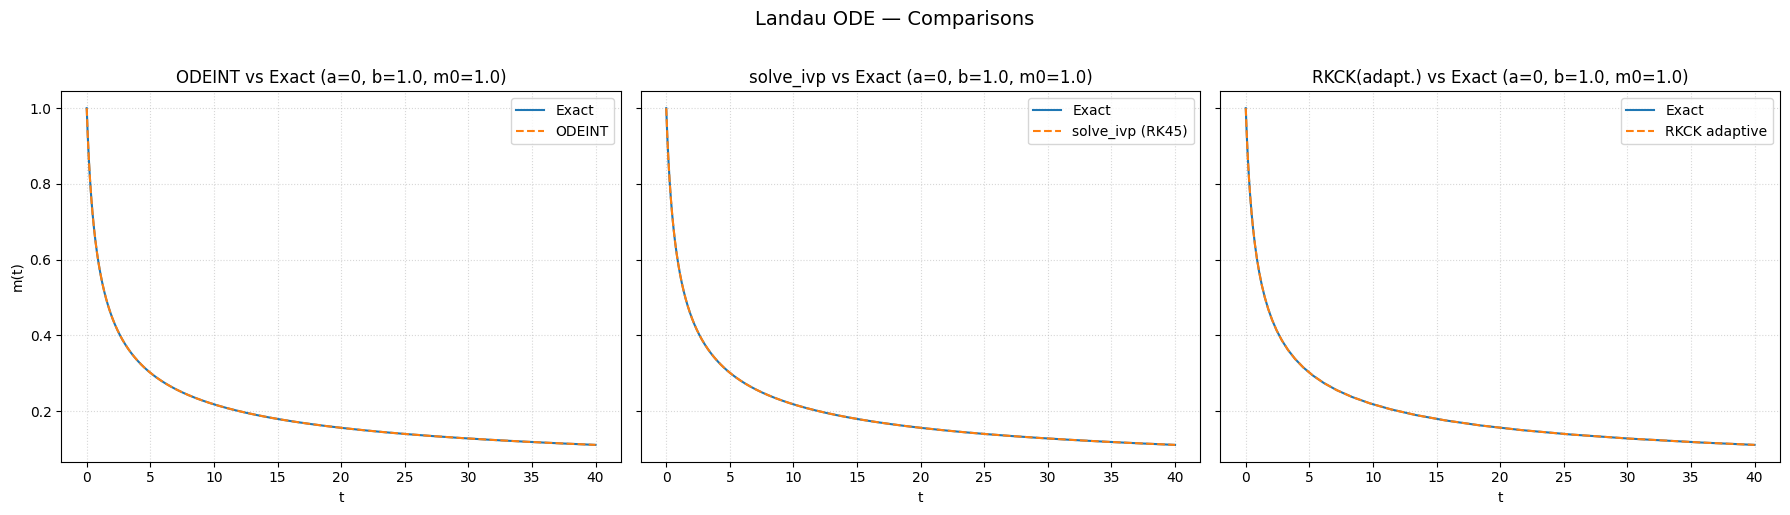

In [ ]:
landau_edo_compare_and_plot(a= 0, b = 1.0, m0 = 1.0 ) # Comportamento começando ordenado no ponto crítico (a=0)

a = 0  → fase marginal (a=0)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1e-06  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.00, m_ODE = 0.00, m_ivp = 0.00, m_rkck = 0.00]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 6.353e-22 ;  RMS rel = 3.814e-16
  SOLVE_IVP → max |Δm| = 4.235e-22 ;  RMS rel = 1.665e-16
  RKCK(adapt.) → max |Δm| = 2.118e-22 ;  RMS rel = 1.132e-16


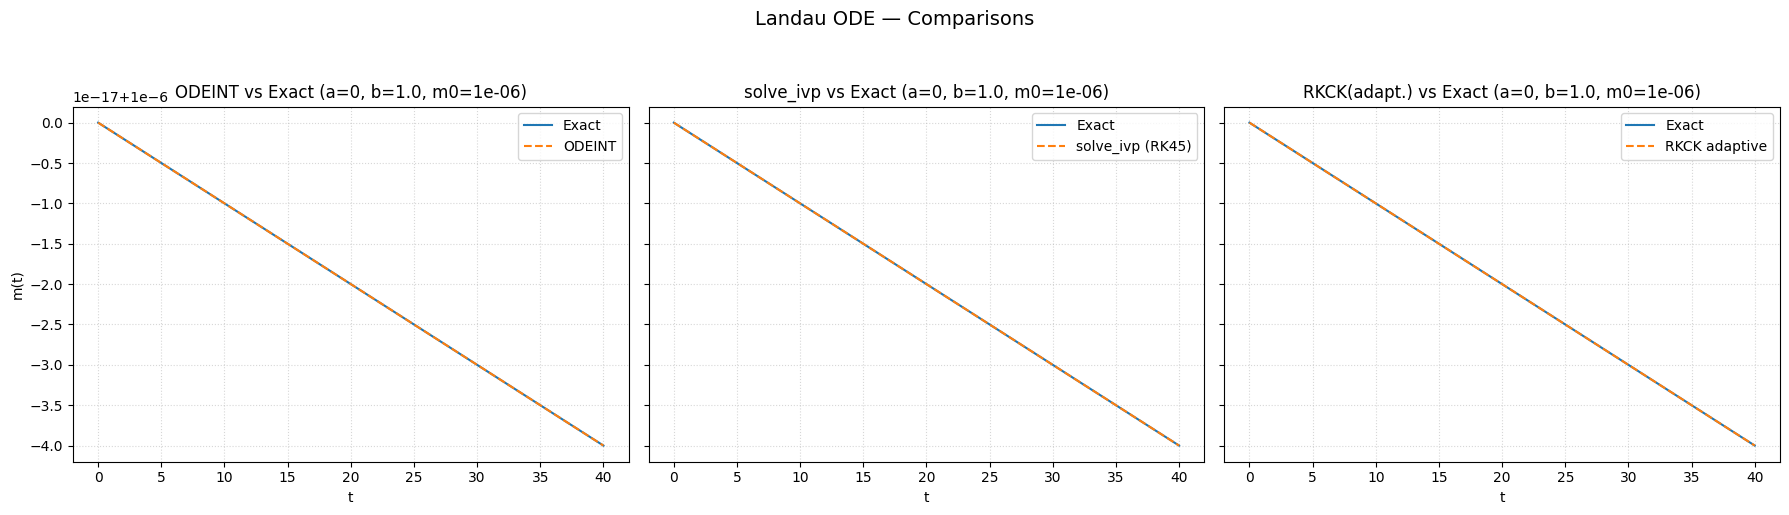

In [ ]:
landau_edo_compare_and_plot(a=0, b=1.0, m0=1e-6) # Começa bem desordenado em cima do ponto crítico (a=0)

**Discussão dos resultados **

Observamos que no regime marginal, i.e., próximo ao ponto crítico (a=0), o decaimento do parâmetro de ordem, m, é mais lento e não vai para nenhuma fase bem definida.

Notamos no primeiro gráfico que, começando de um estado bem ordenado, |m|=1, caminhamos para o desordenamento, ou seja, m $\to 0 $, e no regime assintótico de tempos longos a curva começa a decair de forma proporcional a $m \propto 1/\sqrt{t}$.


Já para m próximo ao deserdonemaneto, $m\approx 0$ (segundo gráfico), observamos um efeito parecido. O parâmetro de ordem continua caindo.

O ponto de criticalidade define justamente o regime marginal, onde qualquer flutuação do sistema o leva a um estado ordenado ou desordenado, fazendo com que assuma um sinal bem definido. Em cima do ponto crítico tendemos ao desordenamento mas de uma maneira bem mais lenta quando comparado a $a > 0$. Esse comportamento se refelete de diversar maneiras no sistema, para o paramagneto observamos a formação de cluster de spins +1 e -1 cuja média era tendia a 0 mas que, com qualquer flutuação da temperatura, fazia um dos grupos se sobrepor aos outros. Abaixo coloco mu gráfico só considerando o regime assintótico

a = 0  → fase marginal (a=0)
b = 1  (espera-se b>0 para estabilidade de Landau)
m0 = 1  → estado inicial ordenado
Janela temporal: [0, 40] com 10000 pontos

Últimos m's medidos: [m_exct = 0.11, m_ODE = 0.11, m_ivp = 0.11, m_rkck = 0.11]
Erros vs. solução exata (resumos):
  ODEINT  → max |Δm| = 3.461e-08 ;  RMS rel = 1.439e-07
  SOLVE_IVP → max |Δm| = 2.032e-08 ;  RMS rel = 3.615e-08
  RKCK(adapt.) → max |Δm| = 7.582e-10 ;  RMS rel = 2.906e-09


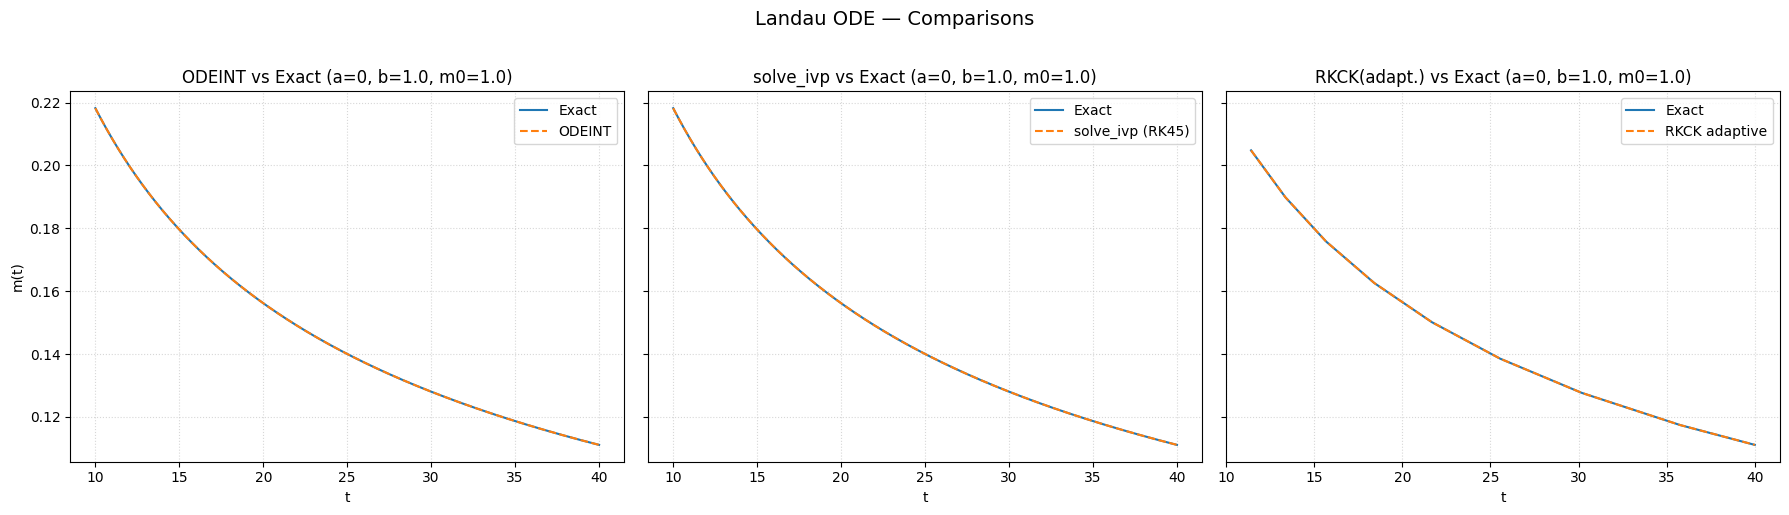

In [ ]:
landau_edo_compare_and_plot_asymptotic(a= 0, b = 1.0, m0 = 1.0 ) # Comportamento começando ordenado no ponto crítico (a=0), assintótico

Acima fica claro o comportamento de $m \propto t^{-1/2}$

### 4. Diagrama de fases descritos nas Eqs.(52-53).

In [ ]:
# ------------------------------------------------
# Diagrama de Fases: utilitários e função principal
# ------------------------------------------------
def _classify_phase(a):
    if a > 0:
        return "desordenada (m→0)"
    elif a < 0:
        return "ordenada (|m|→sqrt(-a/b))"
    else:
        return "marginal (a=0, lei de potência)"

def _expected_equilibrium(a_grid, b, m0):
    """(mantido para compatibilidade; aqui retorna só o ramo com sinal de m0)"""
    m_star = np.zeros_like(a_grid, dtype=float)
    neg = a_grid < 0
    m_star[neg] = np.sign(m0) * np.sqrt((-a_grid[neg]) / b)
    return m_star

def _theory_branches(a_grid, b):
    """
    Retorna os dois ramos teóricos para a<0 e NaN fora deles (para facilitar o plot):
      m+(a) = +sqrt(-a/b), m-(a) = -sqrt(-a/b) se a<0; caso contrário NaN.
    """
    m_pos = np.full_like(a_grid, np.nan, dtype=float)
    m_neg = np.full_like(a_grid, np.nan, dtype=float)
    mask = a_grid < 0
    m_pos[mask] = np.sqrt((-a_grid[mask]) / b)
    m_neg[mask] = -np.sqrt((-a_grid[mask]) / b)
    return m_pos, m_neg

def _m_final_from_tail(values, frac_tail=0.2):
    n = len(values)
    i0 = max(0, int((1.0 - frac_tail) * n))
    return float(np.mean(values[i0:]))

def landau_phase_diagram(
    a_min=-1.0,
    a_max= 1.0,
    n_a=121,
    b=1.0,
    m0=1.0,
    t_start=0.0,
    t_end=100.0,
    n_pts=1000,
    tail_frac=0.2,
    method="all",    # "odeint", "ivp", "rkck", "exact", ou "all"
    relerr=1e-9,
    abserr=1e-12,
    rk_dt_try=None   # passo inicial para RKCK adaptativo
):
    """
    Gera diagrama de fases m_final(a) após evolução até t_end.
    - Plota m_final vs a e sobrepõe os ramos teóricos: m* = ±sqrt(-a/b) (a<0) e m*=0 (a>0).
    - Fundo rosa para a<0 e azul para a>0.
    - Imprime estado em a_min, 0 e a_max.
    """
    a_grid = np.linspace(a_min, a_max, int(n_a))
    t_pts = np.linspace(t_start, t_end, int(n_pts))

    # Ramos teóricos
    m_pos, m_neg = _theory_branches(a_grid, b)

    # Paleta para as curvas numéricas por método
    method_colors = {
        "odeint": "#1E88E5",   # azul
        "ivp":    "#43A047",   # verde
        "rkck":   "#8E24AA",   # roxo
        "exact":  "#D81B60",   # magenta
    }

    def _solve_for_a_grid(solver_name):
        mf = np.zeros_like(a_grid, dtype=float)

        if solver_name == "exact":
            for i, a in enumerate(a_grid):
                m = exact_m(t_pts, m0, a, b)
                mf[i] = _m_final_from_tail(m, frac_tail=tail_frac)

        elif solver_name == "odeint":
            dfdt = lambda t, y, *par: f_rhs(t, y, *par)
            for i, a in enumerate(a_grid):
                m = Odeint(dfdt, m0, t_pts, args=(a, b))
                mf[i] = _m_final_from_tail(m, frac_tail=tail_frac)

        elif solver_name == "ivp":
            dfdt = lambda t, y, *par: f_rhs(t, y, *par)
            for i, a in enumerate(a_grid):
                m = Solve_ivp(dfdt, t_start, t_end, m0, t_pts,
                              relerr=relerr, abserr=abserr, args=(a, b))
                mf[i] = _m_final_from_tail(m, frac_tail=tail_frac)

        elif solver_name == "rkck":
            df_rk = lambda y, t, *par: f_rhs(t, y, *par)
            dt_try = rk_dt_try if rk_dt_try is not None else (t_end - t_start) / 1000.0
            for i, a in enumerate(a_grid):
                ts, ys, _ = integrate_rkck_adaptive(df_rk, t_start, t_end, m0, dt_try,
                                                    epsfrac=relerr, epsabs=abserr, args=(a, b))
                tmin_tail = t_start + (t_end - t_start) * (1.0 - tail_frac)
                mask = ts >= tmin_tail
                mf[i] = float(np.mean(ys[mask])) if np.any(mask) else float(ys[-1])
        else:
            raise ValueError("Método desconhecido. Use 'odeint', 'ivp', 'rkck', 'exact' ou 'all'.")

        return mf

    methods = ["odeint", "ivp", "rkck", "exact"] if method == "all" else [method]

    results = {}
    for mth in methods:
        mf = _solve_for_a_grid(mth)
        results[mth] = mf

        # --------- Plot: um por método, com fundos e ramos teóricos ----------
        fig, ax = plt.subplots(figsize=(7, 4.2))

        # fundos coloridos
        ax.axvspan(a_min, 0.0, facecolor="#fde2e4", alpha=1, zorder=0)  # rosa (a<0)
        ax.axvspan(0.0, a_max, facecolor="#89CFF0", alpha=0.6, zorder=0)  # azul (a>0)

        # ramos teóricos: a<0, linhas cheias (preto)
        ax.plot(a_grid, m_pos, color="black", lw=2.0, label=r"Teórico: $+\,\sqrt{-a/b}$ (a<0)")
        ax.plot(a_grid, m_neg, color="black", lw=2.0)

        # reta em a>0: m=0, tracejada
        ax.hlines(0.0, 0.0, a_max, colors="black", linestyles="--", lw=2.0,
                  label=r"Teórico: $m_\ast=0$ (a>0)")

        # curva numérica do método
        ax.plot(a_grid, mf, color=method_colors.get(mth, "0.3"), lw=1.5,
                label=f"{mth}: $m_\\mathrm{{final}}(a)$")
        ax.plot(a_grid, -mf, color=method_colors.get(mth, "0.3"), lw=1.5)

        ax.set_xlabel("a")
        ax.set_ylabel(r"$m_\mathrm{final}$")
        ax.set_title(f"Diagrama de Fases — método: {mth}")
        ax.set_xlim(a_min,a_max)
        ax.grid(True, linestyle=":", alpha=0.5)
        ax.legend(frameon=False, loc="best")
        plt.tight_layout()
        plt.show()

    # --------- Prints de diagnóstico ----------
    def _interp_value(arr, a_val):
        return float(np.interp(a_val, a_grid, arr))

    for mth in methods:
        print(f"\n[ {mth.upper()} ]")
        for aval in [a_min, 0.0, a_max]:
            mfv = _interp_value(results[mth], aval)
            fase = _classify_phase(aval)
            print(f"a={aval:+.3f}: m_final ≈ {mfv:.6g}  →  {fase}")


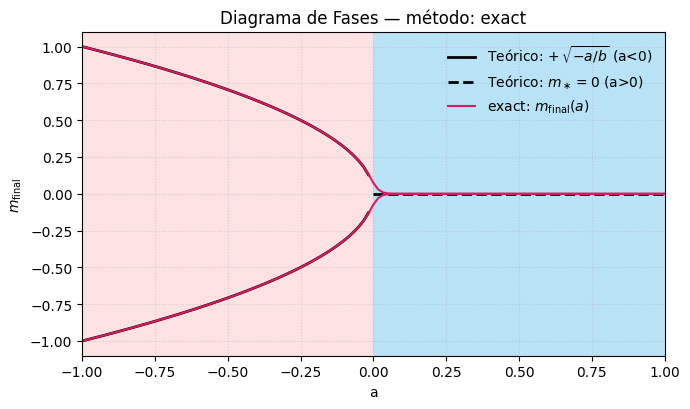


[ EXACT ]
a=-1.000: m_final ≈ 1  →  ordenada (|m|→sqrt(-a/b))
a=+0.000: m_final ≈ 0.0744271  →  marginal (a=0, lei de potência)
a=+1.000: m_final ≈ 6.18356e-37  →  desordenada (m→0)


In [ ]:
landau_phase_diagram(a_min=-1, a_max=1, m0=1, method= "exact" )

**Discussão dos resultados**

Notamos, pelo diagrama de fases acima, que conforme o parâmetro de controle, a, cresce o parâmetro de ordem m diminui, como esperado. A transição ocorre justamente quando a=0, ou seja, quando estamos em cima da temperatura crítica e portanto fazemos a quebra expontânea de simetria.

No gráfico acima podemos observar bem a transição de fase em m=0.

Com isso finalizamos tudo que foi solicitado para a primeira parte da tarefa 5

### Questões finais

1. Discorra sobre a importância das transições de fases na Fisica em geral:

Transições de fase, e a física estatística como um todo, é falar do fio que liga o mundo micro e macro da Física. É nessa transição entre um e outro que surgem fenômenos que observamos aqui: ordem, simetrias quebradas, leis de escala, que não estão “visíveis” nas equações microscópicas de uma partícula isolada, mas epenas do conjunto delas que juntam formam um estado macro bem definido. A transição de fase em si está ligada há muitos dos fenômenos que já discutimos e vimos: o ímã magnetizando, o líquido que solidifica, e até  mesmo transições no universo primordial (minha poesquisa), as mudanças de fase o explicam por que sistemas completamente diferentes compartilham o mesmo comportamento crítico (universalidade que vimos tanto ao longo do curso). É também ali que aparecem conceitos fundamentais visto na teoria de Landau: parâmetros de ordem, classes de universalidade, critical slowing down, etc. Em termos práticos, transições de fase também estão ligadas ao surgemento de novas tecnologias (supercondutividade, superfluidez, materiais magnéticos), e em alta energia/cosmologia orienta o que procurar como “assinaturas” de nova física (minha pesquisa novamente).

Na **teoria de Landau** e dinâmica relaxacional, isso fica bem claro. Assumimos um parâmetro de ordem (m) (medindo o grau de ordenamento) e um parâmetro externo (p) que controla a fase, encapsulado por $(a\propto (p-p_c))$. Consideramos o caso simples, com a energia livre analítica e simétrica sob $(m\to -m)$ que leva à EDO

$$\dot m=-am-bm^3 \qquad (b>0 \text{ p/ estabilidade})$$

que já captura o essencial: para (a>0) (acima de $(p_c)$) o sistema relaxa para a **desordem** $((m\to 0))$; para $(a< 0)$ nasce o **duplo poço** e ocorre **quebra espontânea de simetria**, com $(m(t)\to \pm\sqrt{-a/b})$. Nossos gráficos confirmam ponto a ponto: os três resolvedores numéricos (odeint, solve_ivp e meu RKCK adaptativo) colapsam sobre a solução analítica; no regime assintótico vimos $(m(t)\sim e^{-a t})$ para (a>0), $(m(t)-m_\star\sim e^{2a t})$ para $(a < 0)$ (taxa (2|a|)), e a lei de potência $(m(t)\sim (2bt)^{-1/2})$ no caso marginal (a=0). O **diagrama de fases** $(m_{\text{final}}(a))$ que fizemos bate com as equações do enunciado: zero contínuo para $(a\ge 0)$ e $(|m|=\sqrt{-a/b})$ para $(a< 0)$ (transição de 2ª ordem sob simetria $(m\to -m)$).

Essa moldura teórica é importante porque pode ser bem generelaziada: trocando (m) por magnetização, ordem cristalina (para água), ou mesmo o VEV de um campo escalar $(\phi)$, e os mecanismos são os mesmos. No meu caso de pesquisa (setor escalar/Higgs), o **tipo** da transição (suave vs. 1ª ordem) depende da forma do potencial: termos ímpares/barreiras podem transformar um cenário contínuo em uma transição **de 1ª ordem**, com histerese, nucleação de bolhas e, portanto, **ondas gravitacionais** como assinatura observável.

2. Como a transição de fase pode aparecer em sua grande área de pesquisa ?

A transição de fas está diretamente ligada a minha grande área de pesquisa, que é a cosmologia, além do universo primordial está rodeado de transição de fases (citar exemplos), minha própria área mais específica de pesquisa, ondas gravitacionais geradas por transições de fase de primeira ordem, está totalmente relacionada a esse tópico.

Como já dito anteriormente, o higgs pode ser interpretado como um campo associado a matéria. Pela física de partículas e os colisores e o descobrimento da partícula de higgs é bem conhecido que o mesmo possui uma transição de fase, uma quebra expontânea de simetria, durante a evolução do universo, na escala eletrofraca, pois o higgs está diretamente associado a separação entre a força fraca e a força elétrica (daí que vem a quebra de simetria). Em minha pesquisa em investigo a possibilidade dessa transição ser de primeira ordem e não de segunda ordem como o modelo padrão prevê. A descrição e evolução desse campo após a transição, devido a seu acoplamento com a matéria, pode vir a gerar ondas gravitacionais se uma transição forte de primeira ordem for possível. Isso é interessante pois uma detecção dessas ondas está próxima pelo LISA e EINSTEIN Telescope o que nos perimitirá investiga teorias além do modelo padrão e escalar de energias ainda inacessíveis pelos detectores terrestres.

Abaixo coloco duas referências principais dessa pesquisa:

https://arxiv.org/abs/2305.02357

https://www.researchgate.net/publication/393621793_Cosmological_phase_transitions_from_the_functional_measure

## Parte 2

### Bibliotecas e Funções

In [ ]:
#Libraries that will be used
import random
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import imageio
import scipy.stats
import scipy.optimize
from scipy.interpolate import CubicSpline, interp1d
from scipy.integrate import solve_ivp, odeint
import numpy as np
from IPython.display import HTML
from google.colab import files
from IPython.display import Image
from math import comb
import pandas as pd
from typing import Callable, Tuple, Dict
from collections import namedtuple

In [ ]:
# =========================
# Funções — Parte 2 (EDP)
# =========================

# --------------------------------------------
# 1) RW → coeficientes contínuos (μ, D)
# --------------------------------------------
def compute_mu_D(p: float, dx_rw: float = 1.0, dt_rw: float = 1.0) -> Tuple[float, float]:
    """
    Mapeia o passeio aleatório 1D enviesado para (μ, D):
        μ = (dx_rw/dt_rw) * (2p - 1)
        D = (dx_rw^2 / (2 dt_rw)) * [1 - (2p - 1)^2]
    """
    if not (0.0 <= p <= 1.0):
        raise ValueError("p deve estar em [0,1].")
    mu = (dx_rw / dt_rw) * (2.0*p - 1.0)
    D  = (dx_rw**2 / (2.0*dt_rw)) * (1.0 - (2.0*p - 1.0)**2)
    return float(mu), float(D)

# --------------------------------------------
# 2) Coeficientes adimensionais do FTCS
# --------------------------------------------
def coeffs_A_B(mu: float, D: float, dx: float = 1.0, dt: float = 0.01) -> Tuple[float, float]:
    """
    Coeficientes do esquema FTCS:
        A = μ dt / (2 dx)      (convecção central)
        B = D dt / dx^2        (difusão)
    """
    A = mu * dt / (2.0*dx)
    B = D  * dt / (dx*dx)
    return float(A), float(B)

# --------------------------------------------
# 3) Grade 1D e índice da origem
# --------------------------------------------
def build_grid(xmin: float = -101.0, xmax: float = 101.0, dx: float = 1.0) -> Tuple[np.ndarray, int]:
    """
    Constroi o vetor de posições x ∈ [xmin, xmax] com passo dx e
    retorna também o índice i0 tal que x[i0] = 0 (assumindo 0 no grid).
    """
    nx = int(round((xmax - xmin) / dx)) + 1
    x  = np.linspace(xmin, xmax, nx)
    # índice do nó mais próximo de zero
    i0 = int(np.argmin(np.abs(x)))
    if abs(x[i0]) > 1e-12:
        raise ValueError("0 não está exatamente no grid; escolha xmin/xmax/dx compatíveis.")
    return x, i0

# --------------------------------------------
# 4) FTCS explícito — devolve apenas P(x, t_final)
# --------------------------------------------
def solve_fp_fd(A: float, B: float, n_steps: int, nx: int, i0: int,
                dx: float = 1.0, bc: str = "dirichlet0") -> np.ndarray:
    """
    Integra a Fokker–Planck 1D (convecção-difusão) por FTCS:
        P_i^{n+1} = P_i^n - A (P_{i+1}^n - P_{i-1}^n)
                            + B (P_{i+1}^n - 2 P_i^n + P_{i-1}^n)
    Trabalha com DENSIDADE (∫ P dx ≈ 1). IC: delta discreta na origem via P[i0]=1/dx.
    Condições de contorno:
        - 'dirichlet0' : P=0 nas extremidades (absorvente simples)
        - 'neumann'    : derivada ≈ 0 (espelho simples)    → P[0]=P[1], P[-1]=P[-2]
        - 'periodic'   : contorno periódico                 → P[0]=P[-2], P[-1]=P[1]
    Retorna o vetor P(x, t_final).
    """
    if nx < 3:
        raise ValueError("nx deve ser ≥ 3.")
    P = np.zeros(nx, dtype=float)
    P[i0] = 1.0 / dx  # densidade tipo delta discreta

    for _ in range(int(n_steps)):
        P_old = P.copy()
        # interior
        P[1:-1] = (P_old[1:-1]
                   - A * (P_old[2:] - P_old[:-2])
                   + B * (P_old[2:] - 2.0*P_old[1:-1] + P_old[:-2]))

        # bordas
        if bc == "dirichlet0":
            P[0]  = 0.0
            P[-1] = 0.0
        elif bc == "neumann":
            P[0]  = P[1]
            P[-1] = P[-2]
        elif bc == "periodic":
            P[0]  = P[-2]
            P[-1] = P[1]
        else:
            raise ValueError("bc deve ser 'dirichlet0', 'neumann' ou 'periodic'.")

    return P

# --------------------------------------------
# 5) Solução exata (densidade) e utilidades
# --------------------------------------------
def gauss_exact(x: np.ndarray, t: float, mu: float, D: float) -> np.ndarray:
    """
    Solução exata em espaço infinito (densidade):
        P(x,t) = (4πDt)^(-1/2) exp( - (x - μ t)^2 / (4 D t) ),  t>0.
    """
    if t <= 0.0 or D <= 0.0:
        return np.zeros_like(x)
    pref = 1.0 / np.sqrt(4.0*np.pi*D*t)
    return pref * np.exp(-(x - mu*t)**2 / (4.0*D*t))

def sigma_t(D: float, t: float) -> float:
    """Largura difusiva σ(t) = sqrt(2 D t)."""
    return float(np.sqrt(max(0.0, 2.0*D*t)))

def collapse_vars(x: np.ndarray, P: np.ndarray, t: float, mu: float, D: float
                  ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Reescalonamento para o colapso:
        X = (x - μ t)/σ(t),   P̃ = σ(t) * P(x,t)        (P é densidade)
    """
    sig = sigma_t(D, t)
    if sig == 0.0:
        return (x - mu*t), np.zeros_like(P)
    X = (x - mu*t) / sig
    Ptil = sig * P
    return X, Ptil

def universal_gaussian(X: np.ndarray) -> np.ndarray:
    """Curva universal N(0,1): (2π)^(-1/2) exp(-X^2/2)."""
    return (1.0/np.sqrt(2.0*np.pi)) * np.exp(-0.5*X**2)

# --------------------------------------------
# 6) Wrapper simples (p → solve) sem plot
# --------------------------------------------
def run_system(p: float,
               xmin: float = -101.0, xmax: float = 101.0, dx: float = 1.0,
               dt: float = 0.01, n_steps: int = 10_000,
               dx_rw: float = 1.0, dt_rw: float = 1.0,
               bc: str = "dirichlet0") -> Dict[str, object]:
    """
    Pipeline compacto: p → (μ,D) → (A,B) → resolver FTCS e devolver tudo que importa.
    Nada de plot aqui.
    """
    mu, D = compute_mu_D(p, dx_rw=dx_rw, dt_rw=dt_rw)
    A, B  = coeffs_A_B(mu, D, dx=dx, dt=dt)
    x, i0 = build_grid(xmin=xmin, xmax=xmax, dx=dx)
    P     = solve_fp_fd(A, B, n_steps, len(x), i0, dx=dx, bc=bc)
    out = {
        "p": float(p),
        "mu": float(mu), "D": float(D),
        "A": float(A),   "B": float(B),
        "x": x, "P": P,
        "dx": float(dx), "dt": float(dt),
        "t_final": float(n_steps*dt),
        "bc": bc,
        "i0": int(i0)
    }
    return out

def summarize_system(sys: Dict[str, object]) -> None:
    """Resumo rápido (sem efeitos colaterais no solver)."""
    print(f"p={sys['p']:.3f} | mu={sys['mu']:.6g}  D={sys['D']:.6g} | "
          f"A={sys['A']:.3e}  B={sys['B']:.3e} | "
          f"dx={sys['dx']:.3g} dt={sys['dt']:.3g} t={sys['t_final']:.3g} | BC={sys['bc']}")



In [ ]:
# =========================
# Célula 2 — Funções de Plot
# =========================

def _build_color_map(systems, cmap_name: str = "tab10"):
    """
    Cria um dicionário p -> cor, estável na ordem dos systems.
    """
    cmap = plt.get_cmap(cmap_name)
    uniq_ps = []
    for sys in systems:
        p = float(sys.get("p", len(uniq_ps)))
        if p not in uniq_ps:
            uniq_ps.append(p)
    return {p: cmap(i % 10) for i, p in enumerate(uniq_ps)}

def painel_esquerdo(ax,
                    systems: list[dict],
                    *,
                    colors: dict | None = None,
                    downsample: int = 2,
                    show_exact: bool = True,
                    title: str | None = None) -> None:
    """
    Painel esquerdo: P_num(x,t_final) (marcadores) vs P_exato(x,t_final) (linha),
    usando a MESMA cor para o par numérico/exato de cada p.
    """
    if colors is None:
        colors = _build_color_map(systems)

    for sys in systems:
        x   = sys["x"]
        P   = sys["P"]               # densidade no t_final
        mu  = sys["mu"]
        D   = sys["D"]
        p   = float(sys.get("p", 0.0))
        tf  = float(sys["t_final"])
        c   = colors.get(p, None)

        # numérico (marcadores)
        ax.plot(x[::downsample], P[::downsample], "o", ms=5, alpha=0.85,
                color=c, label=f"Numérico (p={p:.2f}, t={tf:g})")

        # exato (linha)
        if show_exact:
            Pex = gauss_exact(x, tf, mu, D)
            ax.plot(x, Pex, lw=2, color=c, label=f"Exato (p={p:.2f})")

    ax.set_xlabel("x")
    ax.set_ylabel("P(x, t)")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    ax.set_title(title or "Estimado (marcadores) vs Exato (linha)")

def painel_direito_colapso(ax,
                           systems: list[dict],
                           *,
                           colors: dict | None = None,
                           mask_threshold: float = 1e-4,
                           overlay_universal: bool = True,
                           universal_range: tuple[float, float] = (-4, 4),
                           universal_pts: int = 500,
                           title: str | None = None) -> None:
    """
    Painel direito: Colapso difusivo com variáveis reduzidas
        X = (x - μ t)/σ(t),   P̃ = σ(t) P(x,t).
    (Lembrando: aqui P é DENSIDADE, então NÃO dividimos por dx.)
    """
    if colors is None:
        colors = _build_color_map(systems)

    for sys in systems:
        x   = sys["x"]
        P   = sys["P"]
        mu  = sys["mu"]
        D   = sys["D"]
        p   = float(sys.get("p", 0.0))
        tf  = float(sys["t_final"])
        c   = colors.get(p, None)

        X, Ptil = collapse_vars(x, P, tf, mu, D)
        if mask_threshold is not None:
            msk = P > mask_threshold
            X, Ptil = X[msk], Ptil[msk]

        ax.plot(X, Ptil, "o", ms=6, alpha=0.85, color=c, label=f"p={p:.2f} (t={tf:g})")

    if overlay_universal:
        Xg = np.linspace(universal_range[0], universal_range[1], int(universal_pts))
        ax.plot(Xg, universal_gaussian(Xg), "k-", lw=2, label="universal N(0,1)")

    ax.set_xlabel(r"$\tilde X = \frac{x-\mu t}{\sigma(t)}$")
    ax.set_ylabel(r"$\tilde P = \sigma(t)\,P(x,t)$")
    ax.grid(True, ls=":", alpha=0.5)
    ax.legend()
    ax.set_title(title or "Colapso das curvas (reescalonamento difusivo)")

def figura_final(systems: list[dict],
                 *,
                 colors: dict | None = None,
                 figsize: tuple[float, float] = (14, 6),
                 suptitle: str | None = None):
    """
    Monta a figura 1×2 (esquerda: num vs exato; direita: colapso) e retorna (fig, (axL, axR)).
    """
    if colors is None:
        colors = _build_color_map(systems)

    fig, (axL, axR) = plt.subplots(1, 2, figsize=figsize)
    plt.subplots_adjust(wspace=0.30)

    painel_esquerdo(axL, systems, colors=colors)
    painel_direito_colapso(axR, systems, colors=colors)

    if suptitle is None:
        # se todos têm o mesmo t_final, usa no título
        try:
            tf0 = systems[0]["t_final"]
            same_t = all(abs(sys["t_final"] - tf0) < 1e-12 for sys in systems)
            suptitle = (f"Resultados — BC={systems[0]['bc']}, "
                        f"dx={systems[0]['dx']}, dt={systems[0]['dt']}"
                        + (f", t={tf0:g}" if same_t else ""))
        except Exception:
            suptitle = "Resultados numérico vs exato e colapso universal"

    fig.suptitle(suptitle, y=1.03, fontsize=13)
    fig.tight_layout()
    return fig, (axL, axR)


### Resultados e figura final

p=0.400 | mu=-0.2  D=0.48 | A=-1.000e-03  B=4.800e-03 | dx=1 dt=0.01 t=100 | BC=periodic
p=0.500 | mu=0  D=0.5 | A=0.000e+00  B=5.000e-03 | dx=1 dt=0.01 t=100 | BC=periodic
p=0.600 | mu=0.2  D=0.48 | A=1.000e-03  B=4.800e-03 | dx=1 dt=0.01 t=100 | BC=periodic


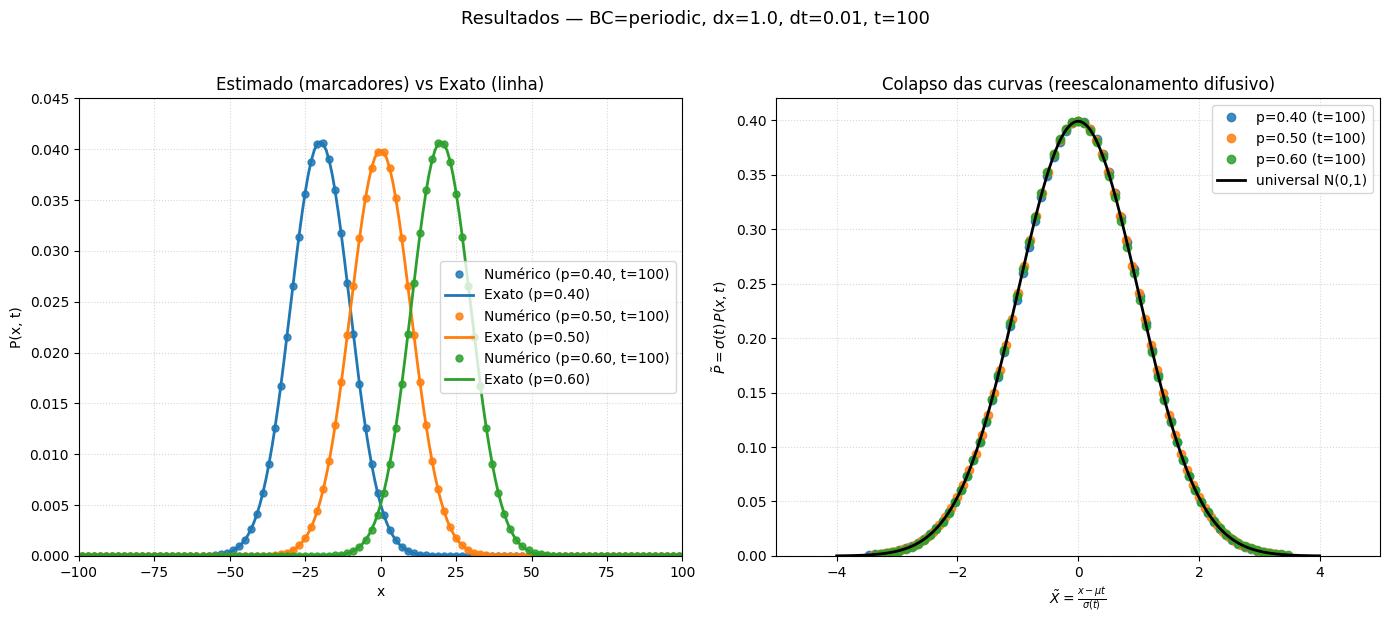

In [ ]:
# =========================
# Execução / Plot final
# =========================

# ----- Parâmetros explícitos -----
dx      = 1.0
dt      = 0.01
N_steps = 10_000               # ⇒ t_final = 100
t_final = N_steps * dt
xmin, xmax = -101.0, 101.0
bc      = "periodic"         # opções: "dirichlet0", "neumann", "periodic"

# RW -> (μ, D)
dx_rw   = 1.0
dt_rw   = 1.0

# Sistemas (p) a comparar
p_list  = [0.4, 0.5, 0.6]

# ----- Resolve cada sistema -----
systems = []
for p in p_list:
    sys = run_system(
        p,
        xmin=xmin, xmax=xmax, dx=dx,
        dt=dt, n_steps=N_steps,
        dx_rw=dx_rw, dt_rw=dt_rw,
        bc=bc
    )
    summarize_system(sys)
    systems.append(sys)

# ----- Figura final: painel esquerdo (num vs exato) + direito (colapso) -----
fig, (axL, axR) = figura_final(systems, figsize=(14, 6))

# Ajustes visuais
axL.set_xlim(-100, 100)
axL.set_ylim(0, 0.045)
axR.set_xlim(-5, 5)
axR.set_ylim(0, 0.42)

plt.tight_layout()
plt.show()


### Questões Finais e Discussão

**Leitura do gráfico final**

No painel da esquerda (BC periódica, (dx=1), (dt=0.01), (t=100)), os pontos são o **numérico (FTCS)** e as linhas são a **solução exata gaussiana**. A concordância é basicamente ponto a ponto. A física por trás é direta:

* O **viés do passeio** entra só pelo **drift** $(\mu=(\Delta x/\Delta t)(2p-1))$:
  $(p=0.4\Rightarrow\mu< 0)$ (pico à esquerda), $(p=0.5\Rightarrow\mu=0)$ (pico em (0)), $(p=0.6\Rightarrow\mu>0)$ (pico à direita).
* A **largura** é **difusiva**: $(\sigma(t)=\sqrt{2Dt})$ com $(D=(\Delta x^2/2\Delta t)[1-(2p-1)^2])$.
  Em outras palavras: (p) fixa $(\mu)$ e (D), e isso já explica praticamente tudo o que vemos.

No painel da direita, fizemos o **colapso difusivo**: reescalamos $(x\to \tilde X=(x-\mu t)/\sigma(t))$ e $(P\to \tilde P=\sigma(t)P(x,t))$. O resultado é que as três curvas (p=0.4, 0.5, 0.6) **ficam em cima da mesma curva universal** $( \mathcal{N}(0,1) )$. Esse é o sinal clássico de **universalidade**: detalhes microscópicos (o valor de (p)) desaparecem quando olhamos as **variáveis adimensionais certas**; o que sobra é a classe universal do processo.

---

**Por que isso é importante (universalidade, em geral)**

Como já vimos na parte 1, no modelo de ising e em outros assuntos envolvendo sistemas termodinâmicos, chegamos a conclusão que: **muitos sistemas bem diferentes** exibem o **mesmo comportamento macroscópico** quando chegam às escalas de interesse. Isso vale:

* em **transições de fase**: críticos térmicos/magnéticos/fluídos compartilham **expoentes críticos** e leis de escala, determinados por **dimensionalidade**, **simetria** e **grau de liberdade efetivo** - O comportamento microscópico no limite termodinâmico desaparece;
* em **processos estocásticos**: o **Teorema Central do Limite** é a versão probabilística dessa ideia (somatórios → gaussianas após reescalonamento);

A utilidade prática disso é: você pode modelar com um **protótipo simples** (como esse feito aqui), extrair **leis de escala/universais**, e ter poder preditivo sobre uma família inteira de sistemas reais, sem precisar conhecer cada detalhe microscópico.

---

**Como isso aparece na minha área (cosmologia e transições de fase)**

Em cosmologia, **transições de fase** aparece em vários estágios do universo primordial: **quebra de simetria eletrofraca**, **transição de confinamento da QCD**, possíveis **setores escuros** etc. Algumas ligações com universalidade são:

1. **Ordens de transição e simetrias:** a classe universal (quebra contínua vs. primeira ordem, conteúdo de simetria, dimensão efetiva) governa **leis de escala** de correlações, **história térmica** e até formação de **defeitos topológicos**.

2. **Background estocástico de ondas gravitacionais (GWs)** em transições **de primeira ordem**:
   se a transição nucleia **bolhas** e elas colidem/agitam o plasma, o espectro de GWs resultante tem uma **forma universal** após reescalonamento por **escala de duração** e **escala de energia** do processo. Muitos micro-modelos diferentes (extensões do setor escalar, acoplamentos extras) caem em **famílias de espectros** muito parecidos quando expressos em unidades naturais da transição.

3. **Eletrofraca e o Higgs:** no **Modelo Padrão** a transição eletrofraca é essencialmente **contínua/ crossover**; várias extensões (mais campos escalares, acoplamentos não padrão) tornam-na **primeira ordem**. Aí entra meu foco: se a transição for **forte e de primeira ordem**, a cinemática de nucleação e colisão de bolhas + turbulência de plasma **produz GWs** potencialmente **detectáveis** pelo **LISA** e por observatórios de 3ª geração (ET). Medindo a forma do espectro, testamos **classes universais de transições** e, com isso, **teorias além do Modelo Padrão** e **escalas de energia** inacessíveis a colisores.

Conectando com os gráficos: o que fizemos com a difusão é um **exemplo pedagógico** do mesmo princípio — **reescale as variáveis certas** e **curvas muito diferentes colapsam**. Em transições de fase cosmológicas, o mesmo acontece: reescalando por tempo característico, temperatura/escala de energia da transição e parâmetros adimensionais (força da transição, velocidade de parede, fração de energia convertida), **espectros de GWs colapsam** para formas **quase universais** dentro de cada regime físico (som turbulento, colisão de bolhas, MHD, etc.). É justamente essa universalidade que permite **inferir física fundamental** a partir de um **sinal astrofísico**.

---

*Referências que guiam essa linha*

* Cosmological phase transitions & functional methods:
  [https://arxiv.org/abs/2305.02357](https://arxiv.org/abs/2305.02357)
